<a href="https://colab.research.google.com/github/RajBharti25/Applied-Data-Science-with-Python/blob/master/BTP_Monalisa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#code to connect drive to colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#SECTION TO LOAD ALL THE REQUIRED LIBRARY
import scipy.io
from numpy import array
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.layers.wrappers import TimeDistributed

# univariate stacked lstm example
from numpy import array
from keras.models import Sequential
# from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.layers.recurrent import LSTM

In [3]:
def split_sequence(sequence,label, n_steps):
	X, y = list(), list()
	for i in range(int(len(sequence))):
		end_ix = i + n_steps
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], label[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

import os, fnmatch
dir= '/content/drive/MyDrive/Colab Notebooks/BTP/LFOVIA/'
listOfFiles = os.listdir(dir+'.')
pattern = "*.mat"
fname=[]
for entry in listOfFiles:
    if fnmatch.fnmatch(entry, pattern):
            fname.append(entry)


feature_len=3
seq_len=6
num=0
X=[]
X=np.array(X)
y=[]
y=np.array(y)
for x in fname:
  mat=scipy.io.loadmat(dir+x)
  a=np.transpose(mat['NIQE_ext'])
  a=(a-np.amin(a))/(np.amax(a)-np.amin(a))
  for l in range(len(a)):
    if(a[l]>1):
      a[l]=1
  b=np.transpose(mat['PSNR_ext'])
  b=(b-np.amin(b))/(np.amax(b)-np.amin(b))
  for l in range(len(b)):
    if(b[l]>1):
      b[l]=1
  c=np.transpose(mat['MSSSIM_ext'])
  d=np.transpose(mat['SSIM_ext'])
  e=np.transpose(mat['STRRED_ext'])
  e=(e-np.amin(e))/(np.amax(e)-np.amin(e))
  for i in range(len(e)):
    if e[i]>1:
      e[i]=1
  f=np.transpose(mat['TSL'])
  g=np.transpose(mat['Nrebuffers'])
  #a='NIQE_ext'
  #b=  'PSNR_ext',
  #c=  'MSSSIM_ext',
  #d=  'SSIM_ext',
  #e=  'STRRED_ext',
  #f= 'TSL'
  #g= 'Nrebuffers'
  xi=a
  xi=np.hstack((xi,b))
  # xi=np.hstack((xi,c))
  # xi=np.hstack((xi,d))
  xi=np.hstack((xi,e))
  # xi=np.hstack((xi,b))
  # xi=np.hstack((xi,g))
  s = np.transpose(mat['score_continuous'])
  s_high = np.transpose(mat['score_continuous_CIhigh'])
  s_low = np.transpose(mat['score_continuous_CIlow'])    
  # s=(s-np.amin(s))/(np.amax(s)-np.amin(s))
  # s_high=(s_high-np.amin(s_high))/(np.amax(s_high)-np.amin(s_high))
  # s_low=(s_low-np.amin(s_low))/(np.amax(s_low)-np.amin(s_low))
  s=s/100
  s_high=s_high/100
  s_low=s_low/100
  s1=s_high-s_low
  yi=s
  yi=np.hstack((yi,s1))
  xi,yi=split_sequence(xi,yi,seq_len)
  if(num==0):
    X=xi
    y=yi
  else:
    X=np.vstack((X,xi))
    y=np.vstack((y,yi))
  num=num+1
X=X.reshape(X.shape[0],seq_len,feature_len)
X.shape,y.shape

((4941, 6, 3), (4941, 2))

In [4]:
model = Sequential()
model.add(LSTM(50, activation='relu',return_sequences=True, input_shape=(seq_len,feature_len)))
model.add(LSTM(30, activation='relu',return_sequences=False))
# model.add(TimeDistributed(Dense(1,activation='relu')))
model.add(Dense(10))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 50)             10800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                9720      
_________________________________________________________________
dense (Dense)                (None, 10)                310       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 20,841
Trainable params: 20,841
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_test.shape)
epsilon=y_test[:,1]
y_train=y_train[:,0]
y_test=y_test[:,0]
# history = model.fit(X, Y, validation_split=0.33, nb_epoch=150, batch_size=10, verbose=0)

(989, 6, 3)


In [7]:
#MODEL TRAINING
model.fit(X_train, y_train, epochs=3, validation_data=(X_test,y_test), batch_size=50)

Epoch 1/3
80/80 [==============================] - 2s 20ms/step - loss: 0.0920 - val_loss: 0.0914
Epoch 2/3
80/80 [==============================] - 2s 19ms/step - loss: 0.0916 - val_loss: 0.0912
Epoch 3/3
80/80 [==============================] - 2s 19ms/step - loss: 0.0915 - val_loss: 0.0912


In [12]:
def OR(x,y,epsilon):
    outage = []
    for i,val in enumerate(epsilon):
        if(abs(x[i]-y[i]) > val):
            outage.append(i)

    return (len(outage)/float(len(epsilon)))*100
x_input = X_test
y_pred = model.predict(x_input)
# y_pred=y_pred[:,3,0]
y_true=y_test
from scipy import stats
sroccc,_=stats.spearmanr(y_true, y_pred)
# sroccc=np.sum(sroccc)
from sklearn.metrics import mean_squared_error
rmse=mean_squared_error(y_true, y_pred, squared=False)
OR1=OR(y_true, y_pred,epsilon)
y_pred=y_pred.reshape(-1,)
y_test=y_test.reshape(-1,)
from scipy import stats
lcc,_=stats.pearsonr(y_true, y_pred)
print('LCC:',round(lcc,4),'  ','  SROCC:',round(sroccc,4),'  ','  RMSE:',round(rmse,4),' ','  OR:',round(OR1))

LCC: 0.5906      SROCC: 0.5303      RMSE: 0.3052     OR: 73


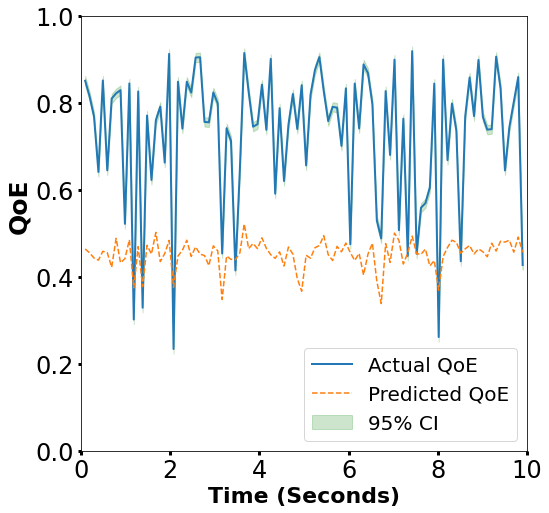

In [13]:
x= np.linspace(0.1, 9.9, 100)
y = y_test[:100]
ci = 0.05 *np.std(y)/np.mean(y)
yhat =y_pred
fig, ax = plt.subplots(1,1,figsize=(8,8))
# fig.suptitle('95% Confidence Interval plot of LFOVIA dataset',color='b',size=14,)

y1=yhat[:100]
#ax.set_title('95% Confidence Interval plot',size=25,horizontalalignment='center',verticalalignment='bottom',weight = 'bold')
ax.fill_between(x, (y-ci), (y+ci), color='g', alpha=.2, label="95% CI")
ax.plot(x,y,label="Actual QoE",linewidth=2, markersize=12,alpha =5)
ax.plot(x,y1,'--',label="Predicted QoE")
plt.ylim((-0,1))
plt.xlim((0,10))
ax.legend(loc=4,prop={'size': 20})
ax.set_ylabel("QoE",size=25,horizontalalignment='left',weight = 'bold')
ax.set_xlabel("Time (Seconds)",size=22,horizontalalignment='center',weight = 'bold')
plt.tick_params(axis='both', which='major', labelsize=24 , width=3)
from PIL import Image
plt.savefig('/content/drive/MyDrive/Colab Notebooks/BTP/LFOVIA_testplot300_2.jpg')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/BTP/LFOVIA_rajp300_2.pdf', bbox_inches='tight')
# Image.open('/content/drive/MyDrive/Colab Notebooks/BTP/testplot.png').save('testplot.jpg','JPEG')

In [25]:
def split_sequence(sequence,label, n_steps):
	X, y = list(), list()
	for i in range(int(len(sequence))):
		end_ix = i + n_steps
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], label[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

import os, fnmatch
dir= '/content/drive/MyDrive/Colab Notebooks/BTP/LIVE_NFLX_PublicData_Release/'
listOfFiles = os.listdir(dir+'.')
pattern = "*.mat"
fname=[]
for entry in listOfFiles:
    if fnmatch.fnmatch(entry, pattern):
            fname.append(entry)

feature_len=3
seq_len=6
num=0
X=[]
X=np.array(X)
y=[]
y=np.array(y)
for x in fname:
  mat=scipy.io.loadmat(dir+x)
  a=np.transpose(mat['NIQE_vec'])
  a=(a-np.amin(a))/(np.amax(a)-np.amin(a))
  for l in range(len(a)):
    if(a[l]>1):
      a[l]=1
  b=np.transpose(mat['PSNR_vec'])
  b=(b-np.amin(b))/(np.amax(b)-np.amin(b))
  for l in range(len(b)):
    if(b[l]>1):
      b[l]=1
  c=np.transpose(mat['MSSIM_vec'])
  d=np.transpose(mat['VMAF_vec'])
  d=(d-np.amin(d))/(np.amax(d)-np.amin(d))
  for l in range(len(d)):
    if(d[l]>1):
      d[l]=1
  e=np.transpose(mat['STRRED_vec'])
  e=(e-np.amin(e))/(np.amax(e)-np.amin(e))
  for i in range(len(e)):
    if e[i]>1:
      e[i]=1
  f=np.transpose(mat['GMSD_vec'])
  xi=a
  xi=np.hstack((xi,b))
  xi=np.hstack((xi,c))
  # xi=np.hstack((xi,d))
  # xi=np.hstack((xi,e))
  # xi=np.hstack((xi,f))
  s = np.transpose(mat['continuous_subj_score'])
  # s=s/100
  xi,s=split_sequence(xi,s,seq_len)
  if(num==0):
    X=xi
    y=s
  else:
    X=np.vstack((X,xi))
    y=np.vstack((y,s))
  num=num+1
X=X.reshape(X.shape[0],seq_len,feature_len)
X.shape,y.shape

((188712, 6, 3), (188712, 1))

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [27]:
x_input = X_test
y_pred = model.predict(x_input)
# # y_pred=y_pred[:,3,0]
y_true=y_test
from scipy import stats
sroccc,_=stats.spearmanr(y_true, y_pred)
# sroccc=np.sum(sroccc)
from sklearn.metrics import mean_squared_error
rmse=mean_squared_error(y_true, y_pred, squared=False)
# OR1=OR(y_true, y_pred,epsilon)
y_pred=y_pred.reshape(-1,)
y_test=y_test.reshape(-1,)
from scipy import stats
# lcc,_=stats.pearsonr(y_true, y_pred)
print(round(sroccc,4),'  ',round(rmse,4))

0.2597    0.88


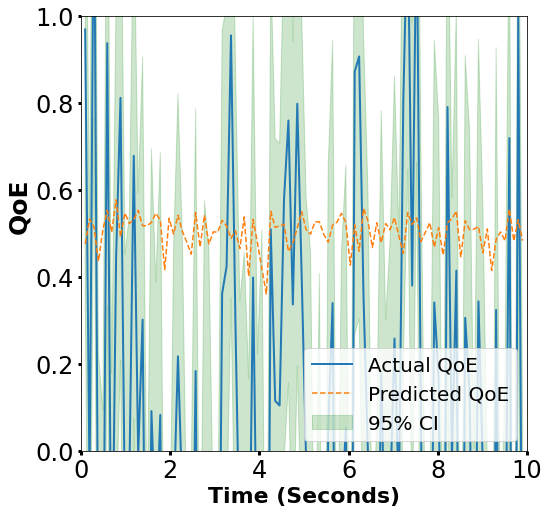

In [28]:
x= np.linspace(0.1, 9.9, 100)
y = y_test[:100]
ci = 0.05 *np.std(y)/np.mean(y)
yhat =y_pred
fig, ax = plt.subplots(1,1,figsize=(8,8))
# fig.suptitle('95% Confidence Interval plot of LFOVIA dataset',color='b',size=14,)

y1=yhat[:100]
#ax.set_title('95% Confidence Interval plot',size=25,horizontalalignment='center',verticalalignment='bottom',weight = 'bold')
ax.fill_between(x, (y-ci), (y+ci), color='g', alpha=.2, label="95% CI")
ax.plot(x,y,label="Actual QoE",linewidth=2, markersize=12,alpha =5)
ax.plot(x,y1,'--',label="Predicted QoE")
plt.ylim((-0,1))
plt.xlim((0,10))
ax.legend(loc=4,prop={'size': 20})
ax.set_ylabel("QoE",size=25,horizontalalignment='left',weight = 'bold')
ax.set_xlabel("Time (Seconds)",size=22,horizontalalignment='center',weight = 'bold')
plt.tick_params(axis='both', which='major', labelsize=24 , width=3)
from PIL import Image
plt.savefig('/content/drive/MyDrive/Colab Notebooks/BTP/LFOVIA_testplot300_2.jpg')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/BTP/LFOVIA_rajp300_2.pdf', bbox_inches='tight')
# Image.open('/content/drive/MyDrive/Colab Notebooks/BTP/testplot.png').save('testplot.jpg','JPEG')